In [2]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [3]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2

In [4]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [5]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [6]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_plateau_length(
    steps: List[Dict], threshold: float = 0.005, window_size: int = 5
) -> int:
    kl_divs = [step["kl_div"] for step in steps]

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(kl_divs) - window_size + 1):
        window = kl_divs[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    steps: List[Dict], threshold: float = 5e-05, window_size: int = 5
) -> int:
    js_divs = [step["js_div"] for step in steps]

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_divs) - window_size + 1):
        window = js_divs[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1

In [7]:
metadata, activations = [], []

for path in glob("observations/metadata*"):
    metadata.extend(load_jsonl(path))

for path in glob("observations/acts*"):
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [8]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

## Feature directions correlations with sensitivity (blowup point)

In [89]:
def get_sae_feature_directions(sae, metadata):
    feature_dirs = []
    for m in metadata:
        obs_feature_dirs = []
        active_feature_ids_start = m["steps_metadata"][0]["active_feature_ids"]
        active_feature_acts_start = m["steps_metadata"][0]["active_feature_acts"]

        active_feature_ids_end = set(m["steps_metadata"][-1]["active_feature_ids"])

        sorted_feature_ids_with_acts = sorted(
            zip(active_feature_ids_start, active_feature_acts_start),
            key=lambda t: t[1],
            reverse=True,
        )

        for feature_id, feature_act in sorted_feature_ids_with_acts[:1]:
            if feature_id not in active_feature_ids_end:
                feature_dir = get_feature_dir(sae, feature_id, feature_act, norm=True)
                obs_feature_dirs.append(feature_dir)

        if len(obs_feature_dirs) == 0:
            continue

        # for feature_id, feature_act in sorted_feature_ids_with_acts[:3]:
        #     feature_dir = get_feature_dir(sae, feature_id, feature_act, norm=True)
        #     obs_feature_dirs.append(feature_dir)

        feature_dirs.append(obs_feature_dirs)

    return feature_dirs

In [90]:
js_dists = [[s["js_dist"] for s in m["steps_metadata"]] for m in metadata]

In [91]:
# Fix leading nans
js_dists = [[0 if pd.isna(j) else j for j in js] for js in js_dists]

In [92]:
sae_feature_dirs = get_sae_feature_directions(sae, metadata)

In [93]:
len(sae_feature_dirs)

4906

In [94]:
sae_feature_dir_alignments = []
random_dir_alignments = []
sensitivities = []

for i, (acts, feature_dirs, js_dist) in enumerate(
    zip(activations, sae_feature_dirs, js_dists)
):
    # Compute perturbation direction
    perturbation = torch.tensor(acts[-1] - acts[0])
    perturbation = perturbation / perturbation.norm()

    # Compute alignments with each SAE feature direction
    feature_alignments = torch.tensor(
        [torch.dot(direction, perturbation).abs().item() for direction in feature_dirs]
    )

    # Use the maximum alignment
    if len(feature_alignments) == 0 or any(torch.isnan(feature_alignments)):
        continue

    max_alignment = feature_alignments.max().item()
    sae_feature_dir_alignments.append(max_alignment)

    sens = find_js_dist_blowup(js_dist)
    sensitivities.append(sens)

    # Random directions
    random_dirs = []
    for _ in range(100):
        random_dir = torch.rand_like(perturbation)
        random_dir = random_dir / random_dir.norm()
        random_dirs.append(random_dir)

    random_alignments = torch.tensor(
        [torch.dot(direction, perturbation).abs().item() for direction in random_dirs]
    )
    max_rand_alignment = random_alignments.max().item()
    random_dir_alignments.append(max_rand_alignment)

In [95]:
len(sae_feature_dir_alignments)

4865

In [98]:
# sae_corr, sae_p_value = stats.pearsonr(sae_feature_dir_alignments, sensitivities)
# rand_corr, rand_p_value = stats.pearsonr(random_dir_alignments, sensitivities)

sae_corr, sae_p_value = stats.spearmanr(sae_feature_dir_alignments, sensitivities)
rand_corr, rand_p_value = stats.spearmanr(random_dir_alignments, sensitivities)

sae_feature_dir_alignments_var = np.var(sae_feature_dir_alignments)
random_dir_alignments_var = np.var(random_dir_alignments)
equal_var = np.allclose(
    sae_feature_dir_alignments_var, random_dir_alignments_var, atol=1e-4
)
t_stat, p_value_random = stats.ttest_ind(
    sae_feature_dir_alignments, random_alignments, equal_var=equal_var
)

results = {
    "sae_dir_alignment_sensitivity_correlation": sae_corr,
    "sae_dir_correlation_p_value": sae_p_value,
    "rand_dir_alignment_sensitivity_correlation": rand_corr,
    "rand_dir_correlation_p_value": rand_p_value,
    "t_statistic_vs_random": t_stat,
    "p_value_vs_random": p_value_random,
    "mean_max_sae_dir_alignment": np.mean(sae_feature_dir_alignments),
    "std_max_sae_dir_alignment": np.std(sae_feature_dir_alignments),
    "mean_max_rand_dir_alignment": np.mean(random_dir_alignments),
    "std_max_rand_dir_alignment": np.std(random_dir_alignments),
}

In [99]:
for k, v in results.items():
    print(f"{k}: {v:.4f}")

sae_dir_alignment_sensitivity_correlation: -0.0041
sae_dir_correlation_p_value: 0.7731
rand_dir_alignment_sensitivity_correlation: -0.0199
rand_dir_correlation_p_value: 0.1657
t_statistic_vs_random: 33.2499
p_value_vs_random: 0.0000
mean_max_sae_dir_alignment: 0.0685
std_max_sae_dir_alignment: 0.0875
mean_max_rand_dir_alignment: 0.0492
std_max_rand_dir_alignment: 0.0073


## Individual feature ablations

In [69]:
ablations_by_rank = defaultdict(list)

for i, (m, acts) in enumerate(zip(metadata, activations)):

    start_prompt = m["start_prompt"]

    with torch.no_grad():
        start_prompt_gpu = torch.tensor(start_prompt).to(device)
        start_logits, cache = model.run_with_cache(start_prompt_gpu)

    active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]

    sorted_feature_ids_with_acts = sorted(
        zip(active_feature_ids, active_feature_acts),
        key=lambda t: t[1],
        reverse=True,
    )

    feature_acts = torch.zeros(sae.W_enc.shape[1])
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)

    for rank, (feature_id, feature_act) in enumerate(sorted_feature_ids_with_acts[:5]):
        fa = feature_acts.clone()
        fa[feature_id] = 0
        ablation_act = sae.decode(fa)

        def hook(act, hook):
            act[:, -1, :] = ablation_act

        with model.hooks(fwd_hooks=[(perturbation_layer, hook)]):
            pert_logits, _ = model.run_with_cache(start_prompt_gpu)

        js_div = comp_js_divergence(pert_logits[:, -1, :], start_logits[:, -1, :])
        js_dist = torch.sqrt(js_div + 1e-8).item()
        ablations_by_rank[rank + 1].append(js_dist)

    if i % 500 == 0:
        print(f"Processed {i} perturbations")

Processed 0 perturbations
Processed 100 perturbations
Processed 200 perturbations
Processed 300 perturbations
Processed 400 perturbations
Processed 500 perturbations
Processed 600 perturbations
Processed 700 perturbations
Processed 800 perturbations
Processed 900 perturbations
Processed 1000 perturbations
Processed 1100 perturbations
Processed 1200 perturbations
Processed 1300 perturbations
Processed 1400 perturbations
Processed 1500 perturbations
Processed 1600 perturbations
Processed 1700 perturbations
Processed 1800 perturbations
Processed 1900 perturbations
Processed 2000 perturbations
Processed 2100 perturbations
Processed 2200 perturbations
Processed 2300 perturbations
Processed 2400 perturbations
Processed 2500 perturbations
Processed 2600 perturbations
Processed 2700 perturbations
Processed 2800 perturbations
Processed 2900 perturbations
Processed 3000 perturbations
Processed 3100 perturbations
Processed 3200 perturbations
Processed 3300 perturbations
Processed 3400 perturbatio

In [72]:
len(ablations_by_rank[1])

5000

In [80]:
df = pd.DataFrame(
    [
        (rank, js_dist)
        for rank, js_dists in ablations_by_rank.items()
        for js_dist in js_dists
    ],
    columns=["Rank", "JS Distance"],
)

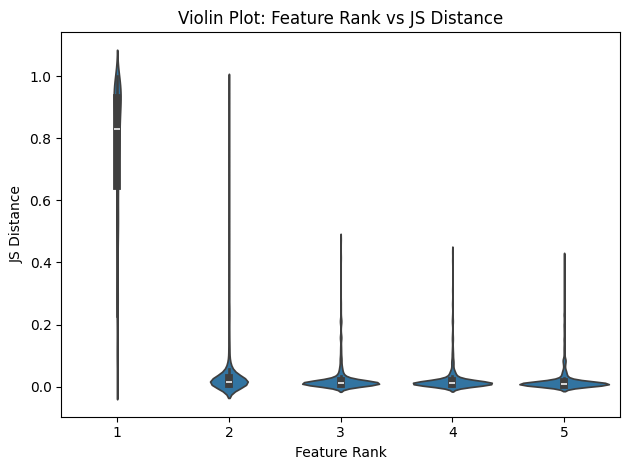

Correlation between Rank and mean JS Distance: -1.000
P-value: 1.404e-24


In [125]:
# Calculate correlation
# We'll use the mean JS distance for each rank for correlation calculation
mean_js_by_rank = df.groupby("Rank")["JS Distance"].mean().reset_index()
correlation, p_value = stats.spearmanr(
    mean_js_by_rank["Rank"], mean_js_by_rank["JS Distance"]
)

# Violin plot
sns.violinplot(data=df, x="Rank", y="JS Distance")
plt.title("Violin Plot: Feature Rank vs JS Distance")
plt.xlabel("Feature Rank")
plt.ylabel("JS Distance")

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print correlation results
print(f"Correlation between Rank and mean JS Distance: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")

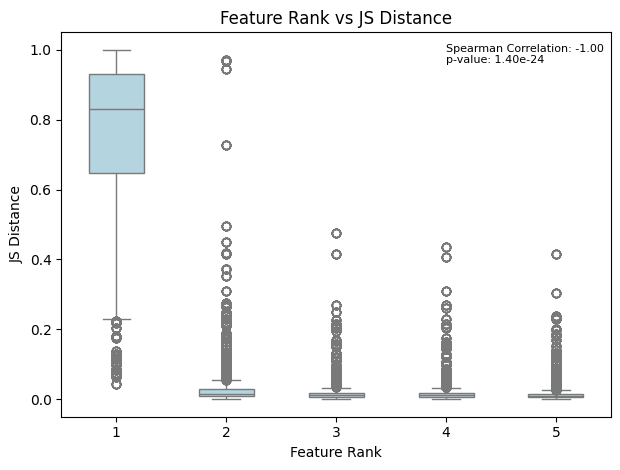

In [132]:
# Create a box plot
sns.boxplot(x="Rank", y="JS Distance", data=df, color="lightblue", width=0.5)

# Overlay with a strip plot
# sns.stripplot(x='Rank', y='JS Distance', data=df, color='tab:pink', alpha=0.5, jitter=True)

# Customize the plot
plt.title("Feature Rank vs JS Distance", fontsize=12)
plt.xlabel("Feature Rank", fontsize=10)
plt.ylabel("JS Distance", fontsize=10)

plt.text(
    0.7,
    0.97,
    f"Spearman Correlation: {correlation:.2f}\np-value: {p_value:.2e}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Cumulative feature ablations

In [91]:
def generate_unique_orderings(top_n=5, num_orderings=100):
    # Generate all possible orderings
    all_orderings = list(itertools.permutations(range(top_n)))

    # If the number of requested orderings is greater than or equal to all possible orderings,
    # return all orderings shuffled
    if num_orderings >= len(all_orderings):
        random.shuffle(all_orderings)
        return all_orderings

    # Otherwise, randomly select num_orderings without replacement
    return random.sample(all_orderings, num_orderings)


def detailed_cumulative_ablations(
    model,
    sae,
    start_prompt,
    active_feature_ids,
    active_feature_acts,
    num_orderings=50,
    top_n=5,
):
    ablation_effects = []

    with torch.no_grad():
        start_prompt_gpu = torch.tensor(start_prompt).to(device)
        start_logits, _ = model.run_with_cache(start_prompt_gpu)

    sorted_feature_ids_with_acts = sorted(
        zip(active_feature_ids, active_feature_acts), key=lambda t: t[1], reverse=True
    )

    top_feature_ids, _ = zip(*sorted_feature_ids_with_acts[:top_n])

    feature_acts = torch.zeros(sae.W_enc.shape[1])
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)

    # Generate unique orderings
    orderings = generate_unique_orderings(top_n, num_orderings)

    for order in orderings:
        random_order = [top_feature_ids[i] for i in order]

        previous_js_dist = 0

        for rank, feature_id in enumerate(random_order, 1):
            fa = feature_acts.clone()
            fa[random_order[:rank]] = 0  # Cumulative ablation
            ablation_act = sae.decode(fa)

            def hook(act, hook):
                act[:, -1, :] = ablation_act

            with model.hooks(fwd_hooks=[(perturbation_layer, hook)]):
                pert_logits, _ = model.run_with_cache(start_prompt_gpu)

            js_div = comp_js_divergence(pert_logits[:, -1, :], start_logits[:, -1, :])
            js_dist = torch.sqrt(js_div + 1e-8).item()

            # Record the change in JS distance caused by this feature
            ablated_ranks = [o + 1 for o in order[:rank]]
            ablation_effects.append((ablated_ranks, js_dist - previous_js_dist))
            previous_js_dist = js_dist

    return ablation_effects

In [138]:
# Main loop
all_ablation_effects = []

idxs = random.sample(range(len(metadata)), 50)

for i in idxs:
    m = metadata[i]
    start_prompt = m["start_prompt"]
    active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]

    ablation_effects = detailed_cumulative_ablations(
        model,
        sae,
        start_prompt,
        active_feature_ids,
        active_feature_acts,
        num_orderings=100,
    )

    all_ablation_effects.extend(ablation_effects)

    if i % 10 == 0:
        print(f"Processed {i} perturbations")

Processed 4540 perturbations
Processed 2580 perturbations
Processed 1710 perturbations
Processed 3770 perturbations
Processed 880 perturbations
Processed 2300 perturbations
Processed 4450 perturbations
Processed 2400 perturbations
Processed 3900 perturbations
Processed 0 perturbations
Processed 4630 perturbations


In [139]:
# import pickle

# with open('all_ablation_effects', 'wb') as f:
#     pickle.dump(all_ablation_effects, f)

In [66]:
# rank_based_df.to_feather('cumulative_ablation_results.feather')
rank_based_df = pd.read_feather("cumulative_ablation_results.feather")

In [67]:
rank_based_df.head()

,Rank,JS Distance,Ablation Type,Feature ID,Activation
0,2,0.000122,Cumulative,8656,0.9304
1,2,0.014668,Cumulative,8656,0.9304
2,2,0.005691,Individual,8656,0.9304
3,2,0.009237,Cumulative,8656,0.9304
4,2,-0.000025,Cumulative,8656,0.9304


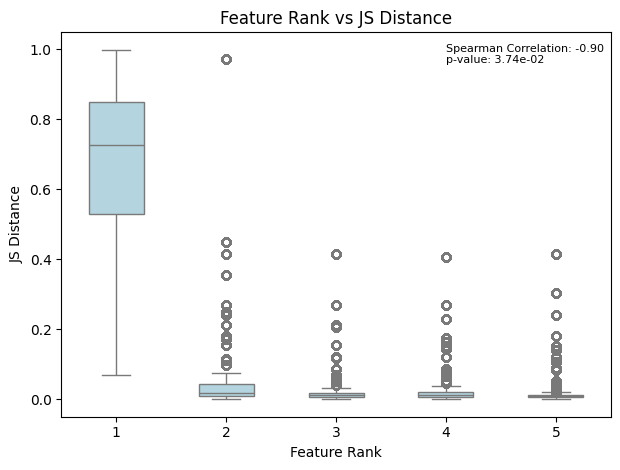

In [11]:
# Replicate individual ablations plot for sanity check
ind_df = rank_based_df[rank_based_df["Ablation Type"] == "Individual"]

mean_js_by_rank = ind_df.groupby("Rank")["JS Distance"].mean().reset_index()
correlation, p_value = stats.spearmanr(
    mean_js_by_rank["Rank"], mean_js_by_rank["JS Distance"]
)

# Create a box plot
sns.boxplot(x="Rank", y="JS Distance", data=ind_df, color="lightblue", width=0.5)

# Customize the plot
plt.title("Feature Rank vs JS Distance", fontsize=12)
plt.xlabel("Feature Rank", fontsize=10)
plt.ylabel("JS Distance", fontsize=10)

plt.text(
    0.7,
    0.97,
    f"Spearman Correlation: {correlation:.2f}\np-value: {p_value:.2e}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    fontsize=8,
)

plt.tight_layout()
plt.show()

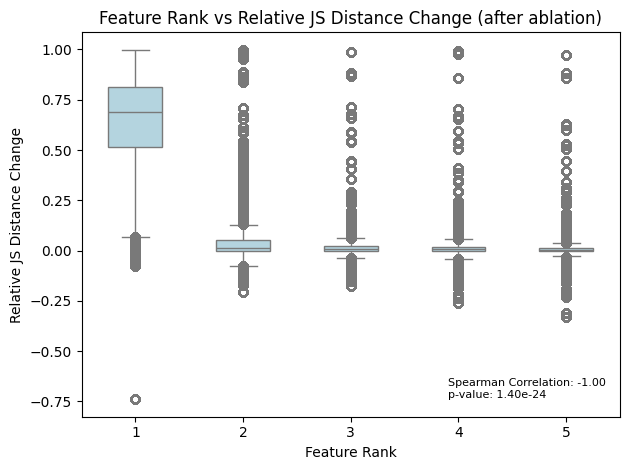

In [270]:
# Cumulative ablations plot
cum_df = rank_based_df[rank_based_df["Ablation Type"] == "Cumulative"]

mean_js_by_rank = cum_df.groupby("Rank")["JS Distance"].mean().reset_index()
correlation, p_value = stats.spearmanr(
    mean_js_by_rank["Rank"], mean_js_by_rank["JS Distance"]
)

# Create a box plot
sns.boxplot(x="Rank", y="JS Distance", data=cum_df, color="lightblue", width=0.5)

# Customize the plot
plt.title("Feature Rank vs Relative JS Distance Change (after ablation)", fontsize=12)
plt.xlabel("Feature Rank", fontsize=10)
plt.ylabel("Relative JS Distance Change", fontsize=10)

plt.text(
    0.68,
    0.1,
    f"Spearman Correlation: {correlation:.2f}\np-value: {p_value:.2e}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    fontsize=8,
)

plt.tight_layout()
plt.show()

In [58]:
import scipy

# Basic statistics
display(rank_based_df.groupby(["Rank", "Ablation Type"])["JS Distance"].describe())

# Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x="Rank", y="JS Distance", hue="Ablation Type", data=rank_based_df)
plt.title("JS Distance Change by Rank and Ablation Type")
plt.xlabel("Feature Rank", fontsize=10)
plt.ylabel("Relative JS Distance Change", fontsize=10)
plt.show()

# Compare individual vs cumulative ablations for each rank
for rank in sorted(rank_based_df["Rank"].unique()):
    ind_data = rank_based_df[
        (rank_based_df["Rank"] == rank)
        & (rank_based_df["Ablation Type"] == "Individual")
    ]["JS Distance"]
    cum_data = rank_based_df[
        (rank_based_df["Rank"] == rank)
        & (rank_based_df["Ablation Type"] == "Cumulative")
    ]["JS Distance"]

    t_stat, p_value = scipy.stats.ttest_ind(ind_data, cum_data)
    print(f"Rank {rank}:")
    print(f"  Individual mean: {ind_data.mean():.4f}")
    print(f"  Cumulative mean: {cum_data.mean():.4f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4e}")
    print()

In [60]:
sns.relplot(
    data=rank_based_df.sample(10_000),
    x="Activation",
    y="JS Distance",
    col="Ablation Type",
    hue="Ablation Type",
    kind="scatter",
)

In [59]:
ind_df = rank_based_df[rank_based_df["Ablation Type"] == "Individual"]

plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=rank_based_df.sample(10_000),
    x="Activation",
    y="JS Distance",
    hue="Ablation Type",
    fill=True,
    levels=10,
)
plt.title("JS Distance Change vs SAE Feature Activation Value (KDE)")
plt.xlabel("SAE Feature Activation")
plt.ylabel("JS Distance Change")
plt.show()

In [70]:
rank_based_df.head()

,Rank,JS Distance,Ablation Type,Feature ID,Activation
0,2,0.000122,Cumulative,8656,0.9304
1,2,0.014668,Cumulative,8656,0.9304
2,2,0.005691,Individual,8656,0.9304
3,2,0.009237,Cumulative,8656,0.9304
4,2,-0.000025,Cumulative,8656,0.9304


In [140]:
# Extract unique ranks from the data
ranks = sorted(
    set(rank for ranks_list, _ in all_ablation_effects for rank in ranks_list)
)

# Initialize the interaction matrix
interaction_matrix = pd.DataFrame(index=ranks, columns=ranks, data=0.0)
count_matrix = pd.DataFrame(index=ranks, columns=ranks, data=0.0)

# Fill the interaction matrix
for ranks_list, effect in all_ablation_effects:
    if len(ranks_list) > 1:
        last_rank = ranks_list[-1]
        for preceding_rank in ranks_list[:-1]:
            interaction_matrix.loc[preceding_rank, last_rank] += effect
            count_matrix.loc[preceding_rank, last_rank] += 1
    else:
        # If only one rank, place the effect on the diagonal
        rank = ranks_list[0]
        interaction_matrix.loc[rank, rank] += effect
        count_matrix.loc[rank, rank] += 1

In [146]:
interaction_matrix_mean = interaction_matrix / count_matrix

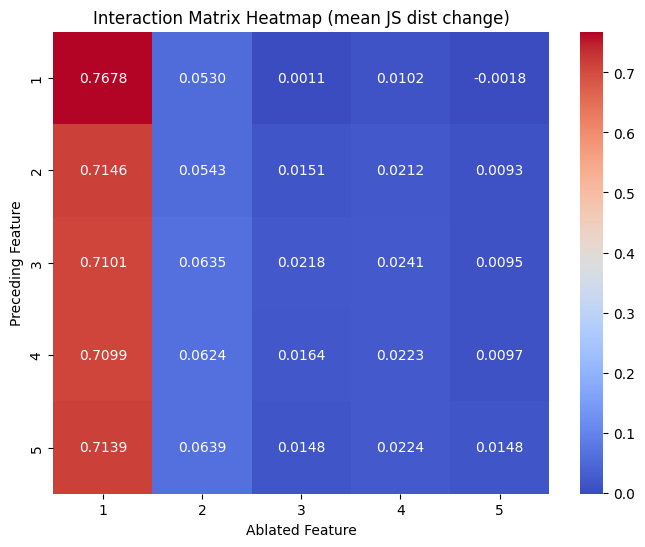

In [169]:
plt.figure(figsize=(8, 6))
sns.heatmap(interaction_matrix_mean, annot=True, cmap="coolwarm", cbar=True, fmt=".4f")
plt.title("Interaction Matrix Heatmap (mean JS dist change)")
plt.xlabel("Ablated Feature")
plt.ylabel("Preceding Feature")
plt.show()

In [167]:
# sns.clustermap(interaction_matrix_mean, annot=True, cmap="coolwarm", cbar=True, fmt=".4f")
# plt.title("Clustered Interaction Matrix Heatmap")
# plt.show()

## Feature Dynamics

In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [172]:
activations.shape

(5000, 100, 768)

## TODO

In [ ]:
def analyze_blowup_dynamics(perturbations_data):
    # Assuming perturbations_data is a list of dictionaries, each containing:
    # 'steps': list of 100 steps
    # 'activations': list of 100 activation vectors
    # 'active_features': list of 100 sets of active feature IDs
    # 'feature_activations': list of 100 dictionaries mapping feature ID to activation level
    # 'kl_divergence': list of 100 KL divergence values

    # 1. Classify blowups
    blowup_steps = [
        np.argmax(p["kl_divergence"] > threshold) for p in perturbations_data
    ]
    median_blowup = np.median(blowup_steps)
    early_blowups = [i for i, step in enumerate(blowup_steps) if step < median_blowup]
    late_blowups = [i for i, step in enumerate(blowup_steps) if step >= median_blowup]

    # 2. Feature Activation Trajectory Analysis
    def analyze_feature_trajectories(perturbation):
        initial_active = set(perturbation["active_features"][0])
        trajectories = {"dampened": [], "activated": [], "rate_of_change": []}
        for step in range(1, 100):
            current_active = set(perturbation["active_features"][step])
            dampened = initial_active - current_active
            activated = current_active - initial_active
            trajectories["dampened"].append(len(dampened))
            trajectories["activated"].append(len(activated))

            prev_activations = perturbation["feature_activations"][step - 1]
            curr_activations = perturbation["feature_activations"][step]
            changes = [
                abs(curr_activations.get(f, 0) - prev_activations.get(f, 0))
                for f in set(curr_activations) | set(prev_activations)
            ]
            trajectories["rate_of_change"].append(np.mean(changes))
        return trajectories

    early_trajectories = [
        analyze_feature_trajectories(perturbations_data[i]) for i in early_blowups
    ]
    late_trajectories = [
        analyze_feature_trajectories(perturbations_data[i]) for i in late_blowups
    ]

    # 3. Critical Step Identification
    def find_critical_step(kl_divergence, window=5):
        changes = np.diff(kl_divergence)
        avg_changes = np.convolve(changes, np.ones(window), "valid") / window
        return np.argmax(avg_changes) + window // 2

    critical_steps = [
        find_critical_step(p["kl_divergence"]) for p in perturbations_data
    ]

    # 4. Pre-Blowup Feature Analysis
    def pre_blowup_features(perturbation, critical_step, window=5):
        start = max(0, critical_step - window)
        active_features = set.union(
            *[
                set(perturbation["active_features"][i])
                for i in range(start, critical_step)
            ]
        )
        avg_activations = {
            f: np.mean(
                [
                    perturbation["feature_activations"][i].get(f, 0)
                    for i in range(start, critical_step)
                ]
            )
            for f in active_features
        }
        return avg_activations

    early_pre_blowup = [
        pre_blowup_features(perturbations_data[i], critical_steps[i])
        for i in early_blowups
    ]
    late_pre_blowup = [
        pre_blowup_features(perturbations_data[i], critical_steps[i])
        for i in late_blowups
    ]

    # 5. Feature Interaction Dynamics
    def extract_feature_interactions(perturbation, critical_step, top_n=10):
        pre_critical = perturbation["feature_activations"][critical_step - 1]
        top_features = sorted(pre_critical, key=pre_critical.get, reverse=True)[:top_n]
        return [pre_critical.get(f, 0) for f in top_features]

    X = np.array(
        [
            extract_feature_interactions(perturbations_data[i], critical_steps[i])
            for i in range(len(perturbations_data))
        ]
    )
    y = np.array(
        [1 if i in early_blowups else 0 for i in range(len(perturbations_data))]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    feature_importance = pd.DataFrame(
        {
            "feature": [f"Feature_{i}" for i in range(X.shape[1])],
            "importance": clf.feature_importances_,
        }
    ).sort_values("importance", ascending=False)

    print("\nTop 10 Important Features for Predicting Early Blowups:")
    print(feature_importance.head(10))

    # Visualizations
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title("Feature Dampening")
    plt.plot(
        np.mean([t["dampened"] for t in early_trajectories], axis=0),
        label="Early Blowups",
    )
    plt.plot(
        np.mean([t["dampened"] for t in late_trajectories], axis=0),
        label="Late Blowups",
    )
    plt.legend()

    plt.subplot(132)
    plt.title("Feature Activation")
    plt.plot(
        np.mean([t["activated"] for t in early_trajectories], axis=0),
        label="Early Blowups",
    )
    plt.plot(
        np.mean([t["activated"] for t in late_trajectories], axis=0),
        label="Late Blowups",
    )
    plt.legend()

    plt.subplot(133)
    plt.title("Rate of Feature Activation Change")
    plt.plot(
        np.mean([t["rate_of_change"] for t in early_trajectories], axis=0),
        label="Early Blowups",
    )
    plt.plot(
        np.mean([t["rate_of_change"] for t in late_trajectories], axis=0),
        label="Late Blowups",
    )
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Heatmap of pre-blowup feature activations
    early_matrix = np.array([list(f.values()) for f in early_pre_blowup])
    late_matrix = np.array([list(f.values()) for f in late_pre_blowup])

    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    sns.heatmap(early_matrix, cmap="viridis")
    plt.title("Early Blowups: Pre-Blowup Feature Activations")

    plt.subplot(122)
    sns.heatmap(late_matrix, cmap="viridis")
    plt.title("Late Blowups: Pre-Blowup Feature Activations")

    plt.tight_layout()
    plt.show()


# Run the analysis
analyze_blowup_dynamics(perturbations_data)

## Plotting

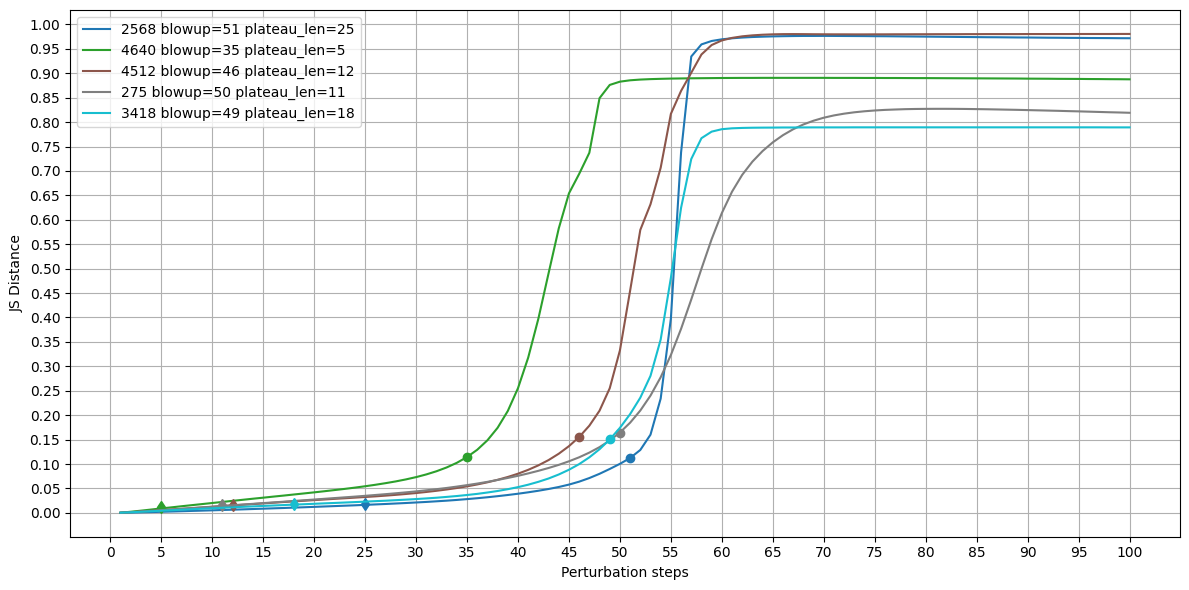

In [185]:
obs_idxs = random.sample(range(len(metadata)), 5)
steps = np.arange(1, 101, 1)

plt.figure(figsize=(12, 6))

# Get the colormap
cmap = plt.get_cmap("tab10")
colors = cmap(np.linspace(0, 1, len(obs_idxs)))

for i, obs_idx in enumerate(obs_idxs):
    props = metadata[obs_idx]
    obs_js_dists = [s["js_dist"] for s in props["steps_metadata"]]
    blowup_step = find_js_dist_blowup(obs_js_dists)
    plateau_len = find_plateau_length_js(props["steps_metadata"])
    label = f"{obs_idx} blowup={blowup_step} plateau_len={plateau_len}"
    plt.plot(steps, js_dists, label=label, color=colors[i])
    plt.plot(
        blowup_step,
        np.interp(blowup_step, steps, js_dists),
        marker="o",
        markersize=6,
        color=colors[i],
    )
    plt.plot(
        plateau_len, js_dists[plateau_len], marker="d", markersize=6, color=colors[i]
    )
    print()


plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.arange(0, 1 + 0.05, 0.05))
plt.xlabel("Perturbation steps")
plt.ylabel("JS Distance")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()